Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, c, sigma]


/home/azureuser/miniconda/envs/llm/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


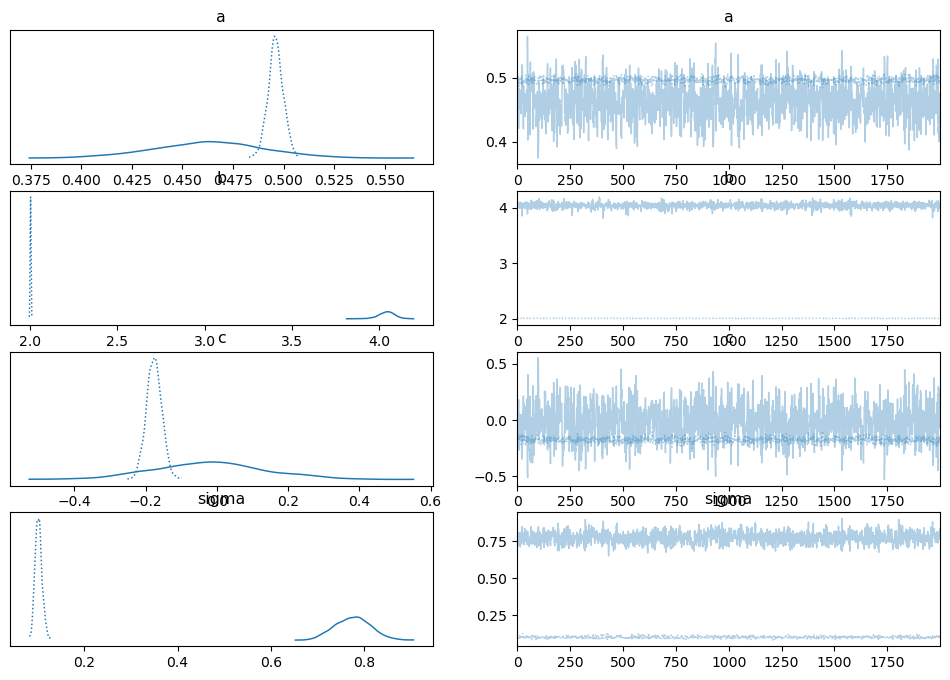

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      0.480  0.026   0.420    0.506      0.012    0.009       5.0      53.0   
b      3.022  1.019   1.997    4.092      0.719    0.609       3.0      55.0   
c     -0.098  0.137  -0.272    0.222      0.058    0.044       7.0      51.0   
sigma  0.439  0.338   0.086    0.821      0.238    0.201       3.0      61.0   

       r_hat  
a       1.48  
b       1.83  
c       1.47  
sigma   1.83  


In [2]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Generate some synthetic data for demonstration
np.random.seed(0)
x = np.linspace(0, 10, 100)
true_a = 0.5
true_b = 2.0
true_c = -0.2
y = true_a * x + np.sin(true_b * x) + true_c + np.random.normal(0, 0.1, size=x.size)

# Define the Bayesian model
with pm.Model() as model:
    # Define priors for a, b, and c
    a = pm.Uniform("a", lower=-1, upper=1)
    b = pm.Uniform("b", lower=0, upper=6)
    c = pm.Uniform("c", lower=-1, upper=1)
    
    # Define the expected value of the model
    y_est = a * x + pm.math.sin(b * x) + c
    
    # Likelihood with observed data (assuming Gaussian noise with standard deviation 0.1)
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    y_obs = pm.Normal("y_obs", mu=y_est, sigma=sigma, observed=y)
    
    # Inference
    trace = pm.sample(2000, tune=1000, cores=2, target_accept=0.9)

# Plot the results
pm.plot_trace(trace)
plt.show()

# Summary of posterior distributions
print(pm.summary(trace))

In [5]:
class InformedBayesRegression():
    def __init__(self):
        pass

    def fit(self, x_context, y_context, knowledge):
        # Define priors for a, b, and c
        a = pm.Uniform("a", lower=-1, upper=1)
        b = pm.Uniform("b", lower=0, upper=6)
        c = pm.Uniform("c", lower=-1, upper=1)

        if knowledge[0, 0] == 1.0:
            a = knowledge[0, 3]
        if knowledge[1, 1] == 1.0:
            b = knowledge[1, 3]
        if knowledge[2, 2] == 1.0:
            c = knowledge[2, 3]
    
        # Define the expected value of the model
        y_est = a * x_context + pm.math.sin(b * x_context) + c
    
        # Likelihood with observed data (assuming Gaussian noise with standard deviation 0.1)
        sigma = pm.HalfNormal("sigma", sigma=0.1)
        y_obs = pm.Normal("y_obs", mu=y_est, sigma=sigma, observed=y_context)
    
        # Inference
        self.trace = pm.sample(2000, tune=1000, cores=2, target_accept=0.9)

        self.summary = pm.summary(self.trace)

    def predict(self, x_target):
        a = self.summary["mean"]["a"]
        b = self.summary["mean"]["b"]
        c = self.summary["mean"]["c"]

        a_std = self.summary["sd"]["a"]
        b_std = self.summary["sd"]["b"]
        c_std = self.summary["sd"]["c"]

        y_mean = a * x_target + np.sin(b * x_target) + c
        y_upper = (a + a_std) * x_target + np.sin(b + b_std) * x_target + c + c_std
        y_lower = (a - a_std) * x_target + np.sin(b - b_std) * x_target + c - c_std

        return y_mean, y_upper, y_lower

In [9]:
sys.path

['/home/azureuser/miniconda/envs/llm/lib/python311.zip',
 '/home/azureuser/miniconda/envs/llm/lib/python3.11',
 '/home/azureuser/miniconda/envs/llm/lib/python3.11/lib-dynload',
 '',
 '/home/azureuser/miniconda/envs/llm/lib/python3.11/site-packages',
 '/mnt/pdata/knk25']

In [10]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from dataset.utils import get_dataloader
from dataset.dataset import *
from argparse import Namespace

# Setup the dataloaders
config = Namespace(
      min_num_context=0,
      max_num_context=100,
      num_targets=100,
      noise=0.2,
      batch_size=1,
      x_sampler='uniform',
      test_num_z_samples=32,
      dataset='set-trending-sinusoids',
      device='cuda:0'
  )

dataset = SetKnowledgeTrendingSinusoids(
  root='../data/trending-sinusoids', split='test', knowledge_type='full'
)
data_loader = get_dataloader(dataset, config)

model = InformedBayesRegression()

for batch in data_loader:
    (x_context, y_context), (x_target, y_target), knowledge, extras = batch
    x_context, y_context, x_target, y_target = x_context[0], y_context[0], x_target[0], y_target[0]
    knowledge = knowledge[0]
    model.fit(x_context, y_context, knowledge)
    y_mean, y_upper, y_lower = model.predict(x_target)
    break

/home/azureuser/miniconda/envs/llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: '../data/trending-sinusoids/data.csv'

In [4]:
pm.summary(trace).loc['a', 'mean']

0.48